# **Estimation des prix de location ( My Dayf )**

## 1- Scrapping :

Scrapping the website mubawab :

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re

# Function to clean text data
def clean_text(text):
    text = text.replace('\n', ' ').replace('\t', ' ').strip()
    return text

# Function to extract numbers from text
def extract_numbers(text):
    # Use regular expressions to extract numbers
    numbers = re.findall(r'\d+', text)
    return ' '.join(numbers)

# Function to scrape data from a single property URL
def scrape_property_details(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Scrape data from div with class 'mainInfoProp'
    main_info = soup.find('div', class_='mainInfoProp')

    # Check if 'mainInfoProp' exists
    if not main_info:
        return None  # Skip if the property structure is different

    # Extract the relevant details and handle missing data by setting "NULL"
    try:
        prix = extract_numbers(clean_text(main_info.find('h3', class_='orangeTit').text))
        if not prix:
            prix = "NULL"
    except:
        prix = 'NULL'

    try:
        emplacement = clean_text(main_info.find('h3', class_='greyTit').text)
        if not emplacement:
            emplacement = "NULL"
    except:
        emplacement = 'NULL'

    try:
        surface = extract_numbers(clean_text(main_info.find('div', class_='disFlex adDetails').find('span').text))
        if not surface:
            surface = "NULL"
    except:
        surface = 'NULL'

    # Now extract 'piece', 'chambre', and 'salle de bain'
    piece = chambre = salle_de_bain = 'NULL'  # Default value if not found

    # Find the div containing property details
    try:
        property_details_div = main_info.find('div', class_='disFlex adDetails')

        if property_details_div:
            # Look for labels like 'Pièces', 'Chambre', 'Salles de bains', etc.
            details = property_details_div.find_all('div')

            for detail in details:
                text = clean_text(detail.text)

                if 'Pièces' in text or 'Pièce' in text:
                    piece = extract_numbers(text)

                if 'Chambres' in text or 'Chambre' in text:
                    chambre = extract_numbers(text)

                if 'Salles de bains' in text or 'Salle de bain' in text:
                    salle_de_bain = extract_numbers(text)

    except:
        pass

    return {
        'prix en MAD': prix,
        'emplacement': emplacement,
        'surface en m²': surface,
        'nombre des pièces': piece,
        'nombre des chambres': chambre,
        'salle_de_bain': salle_de_bain
    }

# Function to extract all the links from the main page
def get_property_links(main_url):
    response = requests.get(main_url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find the ul with class 'ulListing'
    listing_ul = soup.find('ul', class_='ulListing')

    # List to hold the property links
    property_links = []

    if listing_ul:
        # Find all li elements inside the ul
        listings = listing_ul.find_all('li')

        # Loop over each li and extract the 'linkref' attribute
        for listing in listings:
            linkref = listing.get('linkref')
            if linkref:
                property_links.append(linkref)

    return property_links

# Base URL of the listing page
base_url = "https://www.mubawab.ma/fr/st/tanger/appartements-a-louer"

# List to hold all property links
all_property_links = []

# Loop through pages 1 to 56
for page_number in range(1, 57):
    if page_number == 1:
        main_url = base_url
    else:
        main_url = f"{base_url}:p:{page_number}"

    # Get all property links from the listing page
    property_links = get_property_links(main_url)
    all_property_links.extend(property_links)

# Initialize an empty list to store all the scraped data
all_data = []

# Loop through each property link and scrape the details
for link in all_property_links:
    property_data = scrape_property_details(link)  # Use link directly
    if property_data:  # Only append if data was successfully scraped
        all_data.append(property_data)

# Create a pandas DataFrame to store the data
df = pd.DataFrame(all_data)

# Clean the DataFrame if needed
for column in df.columns:
    df[column] = df[column].map(clean_text)

# Remove extra spaces in the 'emplacement' column
df['emplacement'] = df['emplacement'].str.replace(r'\s+', ' ', regex=True)

# Optionally, append to CSV if the file already exists
df.to_csv('scraped_properties_data_tanger.csv', encoding='windows-1252', index=False)

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

## 2-  Data preprocessing :

Delete rows with 0 in "prix en MAD" column

In [ ]:
df = pd.read_csv(r'o.csv', encoding='windows-1252')
df = df[df['prix en MAD'] != 0]

Coding the categorical attribute 'emplacement'

In [ ]:
l = list(df['emplacement'].unique())
n = len(l)
code = {l[i]: i for i in range(n)}
df['emplacementMap'] = df['emplacement'].map(code)
df2 = df.drop(columns=['emplacement'], axis=1)

emplacement_id = {'emplacement': list(code.keys()), 'id': list(code.values())}
emplacement_id = pd.DataFrame(data=emplacement_id)
emplacement_id.to_csv('emplacement_id.csv', index=False)

Handling missing values using KNN imputer

In [ ]:
imputer = KNNImputer(n_neighbors=5)
df2 = pd.DataFrame(imputer.fit_transform(df2), columns=df2.columns)
df2 = df2.round()

df3 = df2[(df2['prix en MAD'] <= 30000) & (df2['prix en MAD'] >= 1000) &
          (df2['surface en m²'] <= 325) & (df2['surface en m²'] >= 50) &
          (df2['emplacementMap'] <= 48) & (df2['nombre des pièces'] <= 10) &
          (df2['nombre des pièces'] > 1) & (df2['nombre des chambres'] > 1)]

## 3-  Training the model :

Split the dataset into training and testing datasets

In [ ]:
X = df3[['surface en m²', 'nombre des pièces', 'nombre des chambres', 'salle_de_bain', 'emplacementMap']]
Y = df3['prix en MAD']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=0)

Create a pipeline for Gradient Boosting Regression with normalization

In [ ]:
gb_pipeline = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('poly_features', PolynomialFeatures(degree=4)),
    ('gb_regressor', GradientBoostingRegressor(n_estimators=70))
])

Fit the model

In [ ]:
# Fit the model
gb_model = gb_pipeline.fit(X_train, y_train)

# Get predictions
gb_predictions = gb_model.predict(X_test)

Gradient Boosting MSE: 16342983.684930172
Gradient Boosting RMSE: 4042.6456294028753
Gradient Boosting R2: 0.5211213977911325


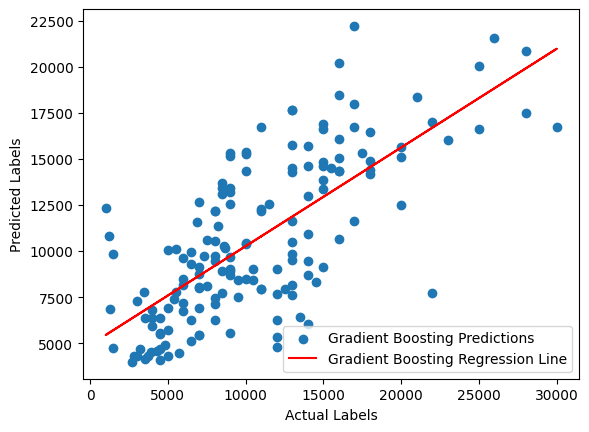

In [ ]:
# Display metrics
mse_gb = mean_squared_error(y_test, gb_predictions)
print("Gradient Boosting MSE:", mse_gb)
rmse_gb = np.sqrt(mse_gb)
print("Gradient Boosting RMSE:", rmse_gb)
r2_gb = r2_score(y_test, gb_predictions)
print("Gradient Boosting R2:", r2_gb)

# Plot predicted vs actual for Gradient Boosting Regression
plt.scatter(y_test, gb_predictions, label='Gradient Boosting Predictions')
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')

# Plot the regression line
z_gb = np.polyfit(y_test, gb_predictions, 1)
p_gb = np.poly1d(z_gb)
plt.plot(y_test, p_gb(y_test), color='red', label='Gradient Boosting Regression Line')

plt.legend()
plt.show()

In [ ]:
import joblib

# Save the model
joblib.dump(gb_model, 'gradient_boosting_model.pkl')

['gradient_boosting_model.pkl']